# Assessment Preparation Challenge 2

* These challenges are optional, are not marked and are just for you.
* But they will prepare you for the course’s final assesment. If you complete all of the challenges, you will have a much easier to do the final assesment.
* you will **NOT** be given answers to them, because large parts of the assesment will be very simmilar and if we gave you the answers you could copy-paste parts of it for assesment which would defeat the purpose of the assesment :)

In [6]:
# run this at the beginning of the class to load all dependancies 
# (you can run things with Shift+Enter keyboard shortcut, or with the RUN button above)

import networkx as nx
import matplotlib.pyplot as plt
import os
from urllib.request import urlopen
from bs4 import BeautifulSoup
import pprint as pp
import requests

## Challenge 2: Modify the code from this week's notebook to crawl an actual online website, not just files on your computer.

You will likely want to change these aspects:
- use simple websites: some websites, like `bbc.co.uk` use a lot of javascript, and take time to load. This means that you might not be able to scrape them by just asking for their html pages with urlopen. Do not look at complex pages, or (as a rather difficult exercise) use selenium. **Some static personal websites are recommended**.
- you might want to limit scraping pages just to those within your website, otherwise a link to twitter will take you to twitter, and you start scraping completely unrelated sources. You could achieve that with an if statment right after
```
link_address = link.get('href', default = link)
```
- limit amount of times your loop will run. Otherwise you might keep going forever. do something like this inside of your while loop:
```
if len(visited_pages) > 20:
     break
```
or even
```
while len(pages_to_visit) > 0 and len(pages_we_visited) < 20:
```

Here are some small web pages without too many links you may consider:
- https://www.edinburghshogmanay.com/
- https://gauss.world/
- https://bagrow.com/

## Here are some codes for you, they might be useful for you, but you might need to tweak to your needs!

In [1]:
# let's visit our starting page, but first we'll make our function return above format of data

def domain_only(full_url):
    without_https = full_url.lstrip("https").lstrip("://")
    end_of_domain = without_https.find("/") if "/" in without_https else len(without_https)
    return without_https[0:end_of_domain]

assert domain_only("https://bbc.co.uk/") == "bbc.co.uk"
assert domain_only("https://bbc.co.uk") == "bbc.co.uk"
assert domain_only("https://bbc.co.uk/news") == "bbc.co.uk"
assert domain_only("http://twitter.com/account") == "twitter.com"
print("tests passed")

tests passed


In [2]:
def protocol_only(full_url):
    if "https://" in full_url:
        return "https://" 
    elif "http://" in full_url:
        return "http://" 
    else:
        return ""

assert protocol_only("https://bbc.co.uk/") == "https://"
assert protocol_only("http://bbc.co.uk") == "http://"
assert protocol_only("bbc.co.uk/news") == ""
print("tests passed")

tests passed


In [3]:
def cleanup_the_link(page_url, link_address, keep_external_links = False):
    if "http" not in link_address: 
        protocol = link_address
        
        #  internal links: if a website https://bbc.co.uk/weather has a link to /news it  means bbc.co.uk/news 
        #  so grab domain and add link at the end
        link_address = protocol_only(page_url) + domain_only(page_url) + link_address
        
    else:
        # only accept external links within this domain, so from https://bbc.co.uk only accept other bbc links
        # to do that strip the https:// and then grab everything before first /
        if domain_only(link_address) != domain_only(page_url) and keep_external_links == False:
            link_address = page_url
    
    if "mailto" in link_address: # also ignore "mailto" email links
        link_address = page_url
    
    if "#" in link_address: # also trim the #id at the end (it tells browser to scroll down)
        link_address = link_address[0:link_address.find("#")]
    if "?" in link_address: # also trim the #id at the end (it tells browser to scroll down)
        link_address = link_address[0:link_address.find("?")]
        
    link_address = link_address.rstrip("/") # cleanup trailing /
        
    return link_address

# if link it to an external website, just replace it with the link to the page it came from
assert cleanup_the_link("https://bbc.co.uk/", "/news") == "https://bbc.co.uk/news"
assert cleanup_the_link("https://bbc.co.uk", "/news") == "https://bbc.co.uk/news"
assert cleanup_the_link("https://bbc.co.uk/news", "/weather") == "https://bbc.co.uk/weather"
assert cleanup_the_link("https://twitter.com", "https://bbc.co.uk/") == "https://twitter.com"
assert cleanup_the_link("https://twitter.com", "https://bbc.co.uk/", True) == "https://bbc.co.uk"


assert cleanup_the_link("https://bbc.co.uk/news", "/weather#footer") == "https://bbc.co.uk/weather"
assert cleanup_the_link("https://bbc.co.uk/news", "/mailto:info@bbc.co.uk") == "https://bbc.co.uk/news"
assert cleanup_the_link("https://bbc.co.uk/news", "/weather?city=edinburgh") == "https://bbc.co.uk/weather"
print("tests passed")

tests passed


In [4]:
def visit_page_and_return_dictionary(page_url, keep_external_links = False):
    #     here I removed a dependency on local holders
    
    link_urls = []
    print(f"Looking for links in {page_url}")
    
    # try catch is there to prtext you from broken links, or links to non-html things, like .pdf .mp3   
    try:
        # this part is new, and required for https:// pages (with security SSL padlock)  
        html_of_website = requests.get(page_url).content.decode()    
    except:
        # if something went wrong, just pretend there were no links.        
        return {'address': page_url, 
                'links_to': []}
    
    soup = BeautifulSoup(html_of_website, 'html.parser')
    links = soup.find_all('a')
    for link in links:
        link_url = link.get('href', default = page_url)
        link_url = cleanup_the_link(page_url, link_url, keep_external_links)
        
        link_urls.append(link_url)
        
    link_urls = list(set(link_urls)) # remove duplicates
        
    return {'address': page_url, 
            'links_to': link_urls}
    
visit_page_and_return_dictionary("https://www.marysmilkbar.com/yourvisit")

Looking for links in https://www.marysmilkbar.com/yourvisit


{'address': 'https://www.marysmilkbar.com/yourvisit', 'links_to': []}

In [7]:
def analyse_website(starting_website, keep_external_links = False):
    pages_we_visited = []
    pages_to_visit = [starting_website] 
    pages_scraped_info = []

    while len(pages_to_visit) > 0 and len(pages_we_visited) < 20: # for now only crawl 10 links
        next_page_to_visit = pages_to_visit.pop() 
        page_info = visit_page_and_return_dictionary(next_page_to_visit, keep_external_links)
        pages_scraped_info.append(page_info)

        pages_we_visited.append(page_info['address']) 
        for link_url in page_info['links_to']:
            if link_url not in pages_we_visited:
                pages_to_visit.append(link_url)

        pages_to_visit = list(set(pages_to_visit)) # remove duplicates

    
#     print()
#     print("pages_we_visited", pages_we_visited)
#     print("pages_to_visit", pages_to_visit)
#     print("pages_scraped_info")
#     pp.pprint(pages_scraped_info)
    return pages_scraped_info
    
scraped_pages = analyse_website("https://www.marysmilkbar.com/")
pp.pprint(scraped_pages)

Looking for links in https://www.marysmilkbar.com/
Looking for links in https://www.marysmilkbar.com
Looking for links in https://www.marysmilkbar.com/dietinfo
Looking for links in https://www.marysmilkbar.com/cart
Looking for links in https://www.marysmilkbar.com/our-story
Looking for links in https://www.marysmilkbar.com/shop
Looking for links in https://www.marysmilkbar.com/yourvisit
[{'address': 'https://www.marysmilkbar.com/',
  'links_to': ['https://www.marysmilkbar.com/our-story',
               'https://www.marysmilkbar.com/shop',
               'https://www.marysmilkbar.com/cart',
               'https://www.marysmilkbar.com/yourvisit',
               'https://www.marysmilkbar.com/dietinfo',
               'https://www.marysmilkbar.com']},
 {'address': 'https://www.marysmilkbar.com',
  'links_to': ['https://www.marysmilkbar.com/our-story',
               'https://www.marysmilkbar.com/shop',
               'https://www.marysmilkbar.com/cart',
               'https://www.marysmi

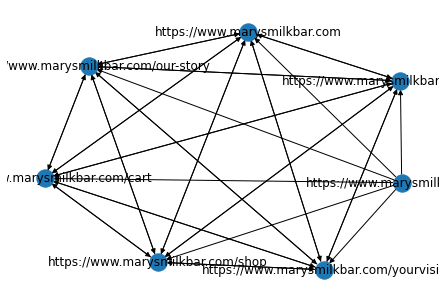

In [8]:
def graph_site_info(pages_info):
    graph = nx.DiGraph()

    for page in pages_info:
        link_origin = page['address']
        all_links = page['links_to']
        for link_destination in all_links:
            graph.add_edge(link_origin, link_destination)

    positions = nx.spring_layout(graph)
    nx.draw(graph, positions, with_labels=True) 
    plt.show()

graph_site_info(scraped_pages)

# most likely you will see a very messy graph. This type of data requires a serious cleanup to be meaningful.
# think how you could clean up this data

Looking for links in https://www.soderberg.uk/
Looking for links in https://www.soderberg.uk/work-with-us
Looking for links in https://www.soderberg.uk/events-edinburgh
Looking for links in https://www.soderberg.uk/pavilion
Looking for links in https://www.soderberg.uk
Looking for links in https://www.soderberg.uk/about
Looking for links in https://www.soderberg.uk/suppliers
Looking for links in https://www.soderberg.uk/our-cafes
Looking for links in https://www.soderberg.uktel:01312258286
Looking for links in https://www.soderberg.uktel:01313322901
Looking for links in https://www.soderberg.uk/soderberg-pavilion
Looking for links in http://www.soderberg.uk
Looking for links in http://www.soderberg.uk/about
Looking for links in http://www.soderberg.uk/the-bakery-1
Looking for links in https://www.soderberg.uk/jazz-sundays
Looking for links in https://www.soderberg.uktel:01312281905
Looking for links in http://www.soderberg.uk/soderberg-soho
Looking for links in http://www.soderberg.uk/

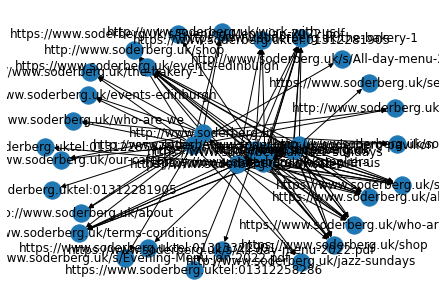

In [9]:
# Let's try some other businesses:

pages_data = analyse_website("https://www.soderberg.uk/")
graph_site_info(pages_data)

**The graph looks not so good, consider how to beautify it!**

Looking for links in https://www.soderberg.uk/
Looking for links in https://www.soderberg.uk/work-with-us
Looking for links in https://www.soderberg.uk/events-edinburgh
Looking for links in https://open.spotify.com/artist/3qeezIehMHTfrEXfZSrT4q
Looking for links in https://open.spotify.com/playlist/1r7O1U8UY7Yu5lxctKnuAW
Looking for links in https://open.spotify.com/user/spotify/playlist/37i9dQZF1DXcaEXdyjLdxm
Looking for links in https://mariannemcgregor.com/home
Looking for links in https://open.spotify.com/track/33ZIaxsct3MDc0oSPxgY76
Looking for links in https://www.soderberg.uk/suppliers
Looking for links in https://open.spotify.com/artist/2DGBzoOLcKLK3eWxFyugdB
Looking for links in https://open.spotify.com/artist/2kVmW0EZG23dqsqeRZ4Jg0
Looking for links in https://open.spotify.com/artist/0YCL71Clky5els6NireSBP
Looking for links in https://open.spotify.com/album/2seGGaGGaVoZdkTwjymdyb
Looking for links in https://open.spotify.com/track/5URFEPzNm7spa1RN7BQvFz
Looking for links in h

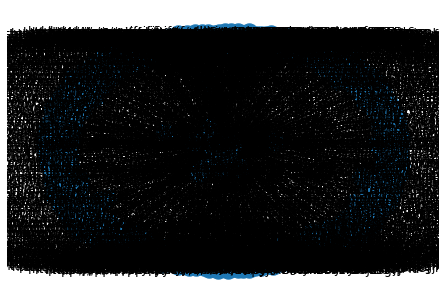

In [10]:
# but notice what happens when you allow crawling external links

pages_data = analyse_website("https://www.soderberg.uk/", True)
graph_site_info(pages_data)

**Not a good visualisation, how to improve it?**